In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import seaborn as sns

In [10]:
df=pd.read_csv("/content/drive/MyDrive/(Final)AgricultureFertilizerdatasets.csv")
df.head()

,Item,Year,Area Harvested (ha),Production (t),Yield (kg/ha),Nutrient nitrogen N (t),Nutrient phosphate P2O5 (t),Nutrient potash K2O (t)
0,"Almonds, in shell",2000,20.0,20.0,1000.0,0.077711,0.027261,0.004626
1,"Almonds, in shell",2001,11.0,11.0,1000.0,0.037411,0.019427,0.000641
2,"Almonds, in shell",2002,11.0,11.0,1000.0,0.016781,0.011782,0.001368
3,"Almonds, in shell",2003,11.0,11.0,1000.0,0.003968,0.003799,0.000735
4,"Almonds, in shell",2004,11.0,11.0,1000.0,0.005858,0.006452,0.001010


In [11]:
df.drop(["Year","Nutrient nitrogen N (t)","Nutrient phosphate P2O5 (t)","Nutrient potash K2O (t)","Yield (kg/ha)"],axis=1, inplace=True)
df.head()


,Item,Area Harvested (ha),Production (t)
0,"Almonds, in shell",20.0,20.0
1,"Almonds, in shell",11.0,11.0
2,"Almonds, in shell",11.0,11.0
3,"Almonds, in shell",11.0,11.0
4,"Almonds, in shell",11.0,11.0


In [12]:
print("------------Check NUll Values -----------------")
print(df.isna().sum())
print("--Duplicated Values--")
print(df.duplicated().sum())


------------Check NUll Values -----------------
Item                    0
Area Harvested (ha)    36
Production (t)         36
dtype: int64
--Duplicated Values--
58


In [13]:
def fillnull_median(df, col):
    df[col] = df[col].fillna(df[col].median())

input_columns = ["Area Harvested (ha)", "Production (t)"]
for col in input_columns:
    fillnull_median(df, col)

print("------------Check Null Values -----------------")
print(df.isna().sum())
print("--Duplicated Values--")
print(df.duplicated().sum())




------------Check Null Values -----------------
Item                   0
Area Harvested (ha)    0
Production (t)         0
dtype: int64
--Duplicated Values--
58


In [14]:
df.drop_duplicates(inplace=True)
print("--Duplicated Values--")
print(df.duplicated().sum())

--Duplicated Values--
0


In [15]:
numeric_cols = ['Area Harvested (ha)', 'Production (t)']

# Filter out outliers based on IQR for each column
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [16]:
df.head()

,Item,Area Harvested (ha),Production (t)
0,"Almonds, in shell",20.0,20.0
1,"Almonds, in shell",11.0,11.0
9,"Almonds, in shell",11.0,9.0
10,"Almonds, in shell",11.0,8.0
11,"Almonds, in shell",18.0,9.0


In [17]:
X=df.copy()
y=X.pop('Item')
print(X.shape)
print(y.shape)


(863, 2)
(863,)


In [18]:
df_clean = X.copy()
df_clean['Label'] = y.values  # Attach original labels to features
duplicates = df_clean[df_clean.duplicated(subset=X.columns, keep=False)]
label_inconsistency = duplicates.groupby(list(X.columns))['Label'].nunique()

#  only the groups with more than 1 unique label (i.e., conflict)
conflicting_duplicates = label_inconsistency[label_inconsistency > 1]
print("Conflicting duplicate rows:")
conflicting_duplicates

Conflicting duplicate rows:


,,Label
Area Harvested (ha),Production (t),
6680.0,27948.00,2
6691.0,27429.00,2
8033.0,35667.72,2
9450.5,22020.50,5


In [19]:
# Identify conflicting feature combinations
conflicting_keys = conflicting_duplicates.index

# # Drop these conflicting rows from the full dataset
mask = df_clean.set_index(list(X.columns)).index.isin(conflicting_keys)
df_clean_no_conflicts = df_clean[~mask]

# # Split features and label again
X_clean = df_clean_no_conflicts.drop('Label', axis=1)
y_clean = df_clean_no_conflicts['Label']


In [20]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_clean,y_clean,test_size=0.2,random_state=45)
if((X_train.shape[0]+X_test.shape[0]==X_clean.shape[0]) and (y_train.shape[0]+y_test.shape[0]==y_clean.shape[0])):
    print("Split sucessfull")
else:
    print("Unsucessful split")


Split sucessfull


In [21]:
X_train.max()

,0
Area Harvested (ha),68500.0
Production (t),81000.0


In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_train_scaled.head()

,Area Harvested (ha),Production (t)
0,-0.309400,1.888885
1,0.443696,0.045264
2,-0.593170,-0.352962
3,-0.283414,0.966348
4,2.594102,0.772834


In [23]:
def model_score(obj):
    if isinstance(obj, LogisticRegression):
        obj.fit(X_train_scaled,y_train)
        return obj.score(X_test_scaled,y_test)
    else:
        obj.fit(X_train, y_train)
    return obj.score(X_test,y_test)
print(model_score(RandomForestClassifier()))
print(model_score(DecisionTreeClassifier()))
print(model_score(LogisticRegression()))


0.6900584795321637
0.6491228070175439
0.2222222222222222


In [24]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize classifier
rf = RandomForestClassifier()

# Grid search (tries every combination)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,  # full grid
    cv=5,                   # 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_clean, y_clean)
best_param=grid_search.best_params_

# Best parameters
print("Best parameters found:", best_param)


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


In [25]:
rf=RandomForestClassifier(n_estimators=best_param['n_estimators'], min_samples_split=best_param['min_samples_split'], min_samples_leaf=best_param['min_samples_leaf'], max_depth=best_param['max_depth'], bootstrap=best_param['bootstrap'])
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)



In [26]:
print(classification_report(y_test, y_pred))


                                                              precision    recall  f1-score   support

                                           Almonds, in shell       1.00      0.80      0.89         5
                                                      Apples       0.33      0.33      0.33         6
                                                    Apricots       0.67      0.67      0.67         3
                                                  Areca nuts       0.86      0.86      0.86         7
                                                     Bananas       1.00      1.00      1.00         1
                                                      Barley       0.71      0.83      0.77         6
                                                  Beans, dry       0.43      0.75      0.55         4
                            Broad beans and horse beans, dry       1.00      1.00      1.00         4
                                                   Buckwheat       0.57      0.80

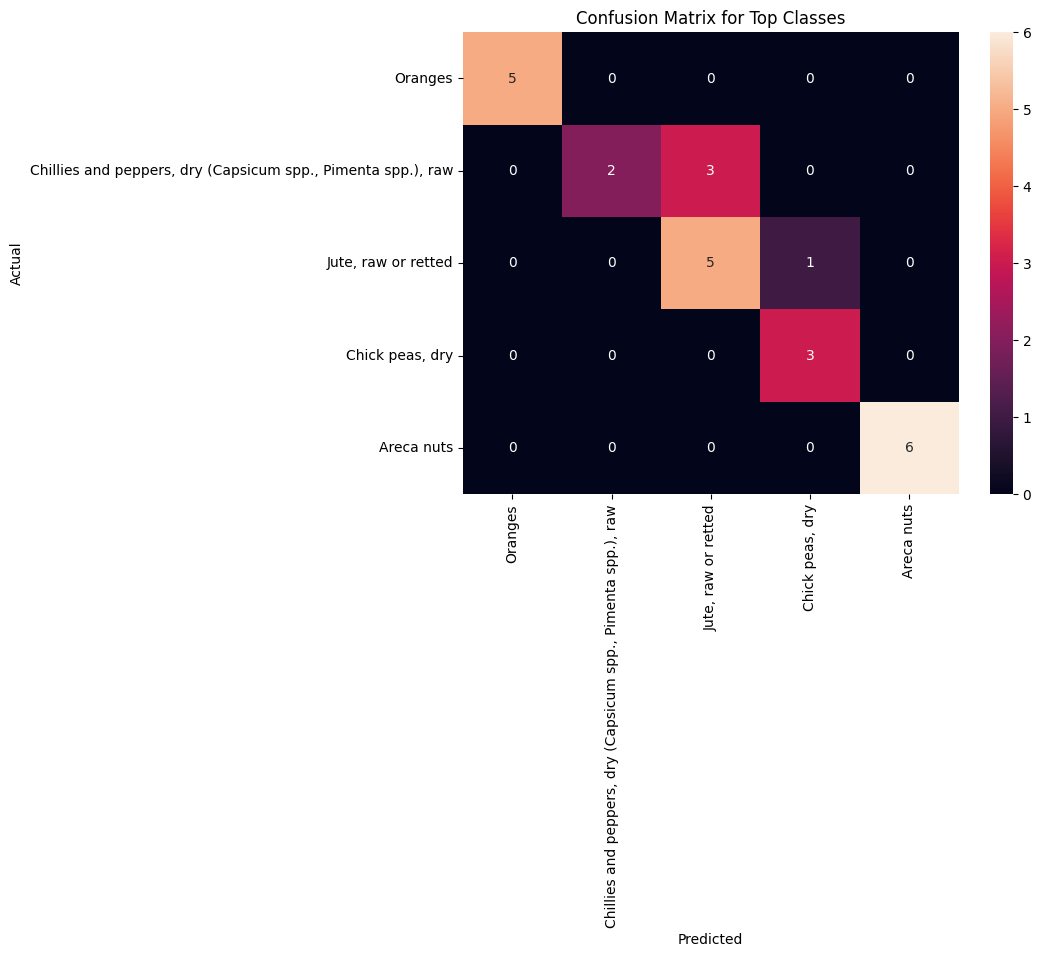

In [27]:
top_classes = y_test.value_counts().nlargest(5).index.tolist()  # Change 5 to 10 if needed

# Step 2: Filter y_test and y_pred to include only those classes
mask = y_test.isin(top_classes)
y_test_filtered = y_test[mask]
y_pred_filtered = pd.Series(y_pred, index=y_test.index)[mask]

# Step 3: Compute confusion matrix only for top classes
cm = confusion_matrix(y_test_filtered, y_pred_filtered, labels=top_classes)

# Step 4: Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=top_classes, yticklabels=top_classes,)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Top Classes')
plt.show()

In [28]:
import joblib

# Save your trained model
joblib.dump(rf, 'cropclassification.pkl')


['cropclassification.pkl']